# Word-Level Text Generation with LSTM

In addition to making predictions, RNNs may also be used as generative models (can learn the sequences and then generate entirely new seqences). One of RNN variant, LSTM neural network has been recognized as a very successful tool when working with sequences of letters or words.

Let's examine performance of basic LSTM model on generating text of fairy tales.

In [11]:
import functions as f

from Text2 import *
from LSTM_class import *

from keras import layers, models, optimizers, callbacks
import matplotlib.pyplot as plt
from transformers import BertTokenizer, GPT2Tokenizer

In [12]:
number_of_recipes = 10000

In [13]:
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

## Text preprocessing

The loaded text file contains the content of tales scraped from websites. By creating the instance of Text object, the text is quickly preprocessed and tokenized; by creating the instance of Sequence object the text is prepared for use in LSTM model.

In [14]:
path_train, path_test = f'data/train_{number_of_recipes}.txt', f'data/test_{number_of_recipes}.txt'

input_train = f.read_txt(path_train)

In [15]:
max_len = 4
step = 3

token2ind = tokenizer.get_vocab()
ind2token = {ind: token for token, ind in token2ind.items()}

text_train = Text2(input_train, token2ind=token2ind, ind2token=ind2token)
text_train.tokens_info()

total tokens: 1351703, distinct tokens: 6103


: 

In [6]:
seq_train = Sequences(text_train, max_len, step)
seq_train.sequences_info()

number of sequences of length 4: 450567


In [7]:
text_train.tokens_ind

[27,
 38827,
 4061,
 36,
 62,
 2257,
 7227,
 29,
 1279,
 21479,
 62,
 2257,
 7227,
 29,
 7586,
 7543,
 1279,
 21479,
 62,
 45,
 13918,
 29,
 2330,
 7543,
 1279,
 21479,
 62,
 45,
 13918,
 29,
 7545,
 1279,
 21479,
 62,
 45,
 13918,
 29,
 9215,
 1279,
 21479,
 62,
 45,
 13918,
 29,
 22397,
 76,
 47205,
 1279,
 21479,
 62,
 45,
 13918,
 29,
 26636,
 9215,
 1279,
 21479,
 62,
 45,
 13918,
 29,
 16858,
 1279,
 21479,
 62,
 10619,
 29,
 1279,
 2751,
 22083,
 40,
 15365,
 62,
 2257,
 7227,
 29,
 352,
 269,
 764,
 7586,
 7543,
 1279,
 2751,
 22083,
 40,
 15365,
 62,
 45,
 13918,
 29,
 352,
 269,
 764,
 2330,
 7543,
 1279,
 2751,
 22083,
 40,
 15365,
 62,
 45,
 13918,
 29,
 352,
 14,
 17,
 269,
 764,
 28959,
 515,
 7545,
 1279,
 2751,
 22083,
 40,
 15365,
 62,
 45,
 13918,
 29,
 362,
 309,
 24145,
 764,
 9215,
 1279,
 2751,
 22083,
 40,
 15365,
 62,
 45,
 13918,
 29,
 352,
 269,
 764,
 28685,
 22397,
 76,
 47205,
 1279,
 2751,
 22083,
 40,
 15365,
 62,
 45,
 13918,
 29,
 513,
 14,
 19,
 269,
 

The text is split into sequences of length 4 (max_len parameter) with step 3. We can see that the first sequence of 4 words starts with the first (0-index) word and the second sequence starts after 3 words, so from the 4th word (3-index).

In [8]:
print(text_train.tokens[:10])
print(text_train.tokens_ind[:10], '\n')

np.array(seq_train.sequences[:2])

['<', 'REC', 'IP', 'E', '_', 'ST', 'ART', '>', 'Ġ<', 'NER']
[27, 38827, 4061, 36, 62, 2257, 7227, 29, 1279, 21479] 



array([[   27, 38827,  4061,    36],
       [   36,    62,  2257,  7227]])

TextDataGenerator is a Python generator that outputs batches of data (sequences and corresponding next words). Since the vocabulary size is over 25k, it's impossible to fit all data to the memory and that's why batch generator is extremely useful.

## Training the LSTM model

We'll build a simple model with one LSTM layer, dropout and dense layer with softmax activation (to return word probabilities).

In [7]:
def lstm_model(sequence_length, vocab_size, layer_size, embedding=False):
    model = models.Sequential()
    model.add(layers.Embedding(vocab_size, layer_size))
    model.add(layers.Bidirectional(layers.LSTM(layer_size, return_sequences = True)))    
    model.add(layers.Dropout(0.3))
    model.add(layers.LSTM(layer_size))
    model.add(layers.Dense(vocab_size, activation='softmax'))
    return model

## Text generation with LSTM model with Embedding layer

The previous model was taking as an input the sequences of words represented as one-hot vectors. In the second approach, we'll feed indexes of words to the model and train the Embedding layers which will create word representations.

In [8]:
batch_size_emb = 1024

params_emb = {
    'sequence_length': max_len,
    'vocab_size': tokenizer.vocab_size,
    'batch_size': batch_size_emb,
    'shuffle': True,
    'embedding': True
}

train_generator_emb = TextDataGenerator(seq_train.sequences, seq_train.next_words, **params_emb)

In [11]:
len(train_generator_emb)

440

In [9]:
model_emb = lstm_model(max_len, tokenizer.vocab_size, 512, True)
optimizer = optimizers.RMSprop(lr=0.001)
model_emb.compile(loss='categorical_crossentropy', optimizer=optimizer)

C:\Users\Viver\AppData\Roaming\Python\Python38\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [13]:
model_emb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 512)         25731584  
                                                                 
 bidirectional (Bidirectiona  (None, None, 1024)       4198400   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 1024)        0         
                                                                 
 lstm_1 (LSTM)               (None, 512)               3147776   
                                                                 
 dense (Dense)               (None, 50257)             25781841  
                                                                 
Total params: 58,859,601
Trainable params: 58,859,601
Non-trainable params: 0
____________________________________________

In [14]:
early_stopping_callback = callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)


In [15]:
history = model_emb.fit(
    train_generator_emb,
    steps_per_epoch=len(train_generator_emb),
    epochs=5,
    verbose=1,
    callbacks=[
        early_stopping_callback
    ]
)

Epoch 1/5
440/440 [==============================] - 614s 1s/step - loss: 1.9266
Epoch 2/5
440/440 [==============================] - 540s 1s/step - loss: 1.4287
Epoch 3/5
440/440 [==============================] - 626s 1s/step - loss: 1.3827
Epoch 4/5
440/440 [==============================] - 659s 1s/step - loss: 1.3689
Epoch 5/5
440/440 [==============================] - 632s 1s/step - loss: 1.3660


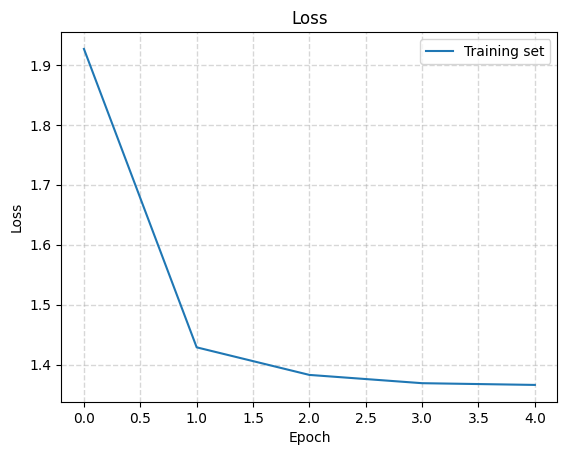

In [18]:
def render_training_history(training_history):
    loss = training_history.history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history)

In [19]:
model_emb.save(f'data/out/blstm_model_{number_of_recipes}_emb_gpt_tokenizer')

INFO:tensorflow:Assets written to: data/out/blstm_model_10000_emb_gpt_tokenizer\assets


INFO:tensorflow:Assets written to: data/out/blstm_model_10000_emb_gpt_tokenizer\assets


In [7]:
model_emb = models.load_model(f'data/out/blstm_model_{number_of_recipes}_emb_gpt_tokenizer')

In [8]:
token2ind, ind2token = text_train.token2ind, text_train.ind2token

RECIPE_START_TOKEN = '<RECIPE_START>'
NER_START_TOKEN = ' <NER_START> '
sample_ner = 'brown sugar'

input_prefix = f'{RECIPE_START_TOKEN}{NER_START_TOKEN}{sample_ner}'
text_prefix = Text2(input_prefix, token2ind, ind2token)

In [9]:
pred_emb = ModelPredict(model_emb, text_prefix, token2ind, ind2token, max_len, embedding=True)

In [10]:
temperatures = [1, 0.7, 0.4, 0.1]

for temperature in temperatures:
  print('temperature:', temperature)
  print(pred_emb.generate_sequence(100, temperature=0.7))
  print('\n')

temperature: 1
1/1 [==============================] - 0s 38ms/step
<RECIPE_START> <NER_START> brown sugar, uncovered, add 1/2 (3/4/2). <INSTRUCTIONS\u00N - <INSTRUCTIONS for 20 - purpose) <INGRED and salt after bananas. <INSTRUCTIONS for about 8 to 12 x 9 - inch pan. <INSTRUCTIONS and serve with spoon with crackers and eggs. <INSTRUCTIONS with vegetables. <INSTRUCTIONS. <INSTRUCTIONS <INSTRUCTIONS, stirring inEND until melted. <INSTRUCT


temperature: 0.7
1/1 [==============================] - 0s 33ms/step
<RECIPE_START> <NER_START> brown sugar <INGRED. <INSTRUCTIONS. Stir. Bake at 350\u00 bottleEND of corn. Combine ingredients. <INSTRUCTIONS with potatoes. <INSTRUCTIONS for 3 hour. <INSTRUCTIONS. <INSTRUCTIONS. <INSTRUCTIONS or 350\uerkraut or raw carrots vinegar ; 1/2/Ny Pepper. <INSTRUCTIONS, add mixture and bake at 325\uerkraut. <INSTRUCTIONS, then marin carrots


temperature: 0.4
1/1 [==============================] - 0s 31ms/step
<RECIPE_START> <NER_START> brown sugar and put in 